<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/exercices-solutions/04_Transfer_Learning_with_TensorFlow_Part_1_Feature_Extraction_Exercice_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 - Transfer Learning with TensorFlow Part 1: Feature Extraction Exercice Solutions

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction from TensorFlow Hub. How does it perform compared to our other mdoels?
2. Name 3 different image classification models on TensorFlow Hub that we haven't used.
3. Build a model to classify images of two different things you've taken photos of.
- You can use any feature extraction layer from TensorFlow Hub you like for this.
- You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.
4. What is the current best performing model on ImageNet?

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# 1. Build and fit a model using the same data `10_food_classes` but with the MobileNetV2 architecture feature extraction from TensorFlow Hub


## 1.1 Get the data

In [2]:
# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-09-26 18:27:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   234MB/s    in 0.7s    

2022-09-26 18:27:01 (234 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# extract the data inside the zip file
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
# explore the data folder
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"{dirpath} contains : {len(dirnames)} directories, {len(filenames)} files")

10_food_classes_10_percent contains : 2 directories, 0 files
10_food_classes_10_percent/test contains : 10 directories, 0 files
10_food_classes_10_percent/test/sushi contains : 0 directories, 250 files
10_food_classes_10_percent/test/chicken_wings contains : 0 directories, 250 files
10_food_classes_10_percent/test/ice_cream contains : 0 directories, 250 files
10_food_classes_10_percent/test/chicken_curry contains : 0 directories, 250 files
10_food_classes_10_percent/test/pizza contains : 0 directories, 250 files
10_food_classes_10_percent/test/fried_rice contains : 0 directories, 250 files
10_food_classes_10_percent/test/steak contains : 0 directories, 250 files
10_food_classes_10_percent/test/ramen contains : 0 directories, 250 files
10_food_classes_10_percent/test/grilled_salmon contains : 0 directories, 250 files
10_food_classes_10_percent/test/hamburger contains : 0 directories, 250 files
10_food_classes_10_percent/train contains : 10 directories, 0 files
10_food_classes_10_percent

Our training directories have 75 images per classes rather than the test directories which have 250 images per classes.

In [5]:
# Get the class names
import pathlib 

data_dir = pathlib.Path("10_food_classes_10_percent/train/")

for i in data_dir.glob("*"):
  print(i.name)

sushi
chicken_wings
ice_cream
chicken_curry
pizza
fried_rice
steak
ramen
grilled_salmon
hamburger


In [6]:
# get the class names in an array
import numpy as np
class_names = np.array(sorted([i.name for i in data_dir.glob("*")]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

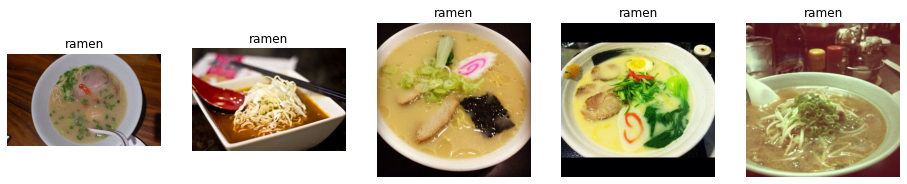

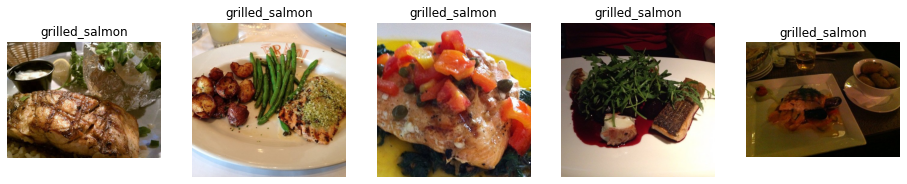

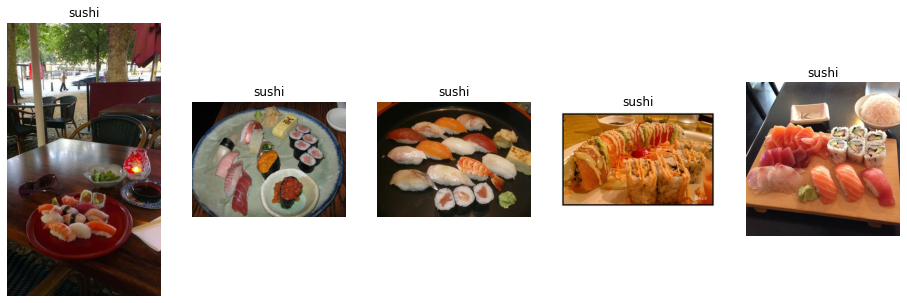

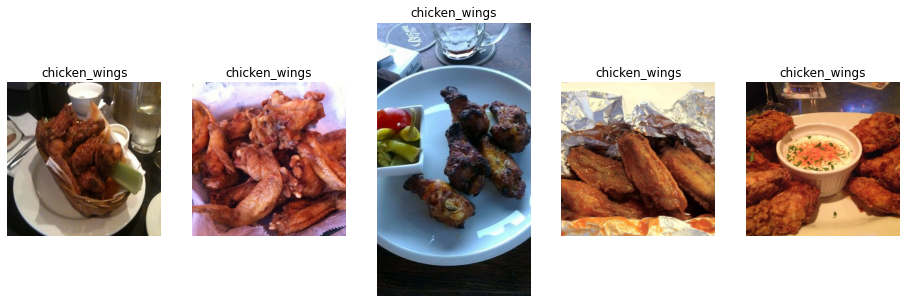

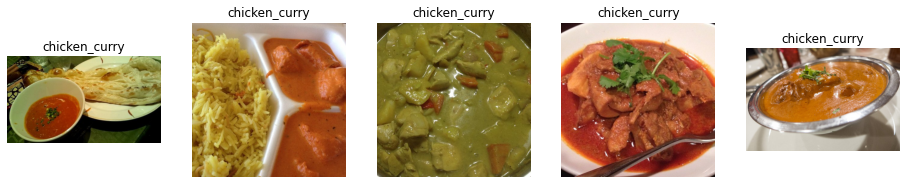

In [7]:
# visualize the data
import random
import matplotlib.image as mpimg

number_images = 5
number_classes = 5
dirname = "10_food_classes_10_percent/train/"
random_classes = random.sample(os.listdir(dirname),number_classes)

for item_class in random_classes:

  # select random images
  random_images = random.sample(os.listdir(f"{dirname}/{item_class}"),number_images)

  # create subplots
  fig, ax = plt.subplots(1,number_images,figsize=(16,8))
  
  for i in range(number_images):
    
    # read the image
    img = mpimg.imread(f"{dirname}/{item_class}/{random_images[i]}")
    
    # plot the image
    ax[i].imshow(img)
    ax[i].set_title(item_class)
    ax[i].axis('off')
  
  plt.show()

## 1.2 Preparing the data

In [8]:
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

# directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# data generator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# prepare data
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


We can see we've got 750 images for the training dataset (75 per class) and 2500 images for the test dataset (250 per class)

### 1.3 Create a TensorBoard callback

The TensorBoard callback is a functionality we can add to our models to be performed during or after the training. THe TensorBoard logs the performance of multiple models and then view and compare these models in a visual board.

In [9]:
# Create a TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  # path of the directory where to save the log files to be parsed by Tensorboard
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

  # tensorboard callback
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  print(f"Saving Tensorboard log files to :{log_dir}")

  return tensorboard_callback